##Przygotowanie środowiska i wczytanie danych


In [0]:

from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, current_date
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [0]:
dbutils.fs.ls("/FileStore/tables")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/data-1.csv', name='data-1.csv', size=45580638, modificationTime=1748636354000),
 FileInfo(path='dbfs:/FileStore/tables/data-2.csv', name='data-2.csv', size=45580638, modificationTime=1748880554000),
 FileInfo(path='dbfs:/FileStore/tables/data-3.csv', name='data-3.csv', size=45580638, modificationTime=1748880688000),
 FileInfo(path='dbfs:/FileStore/tables/data.csv', name='data.csv', size=45580638, modificationTime=1748378075000),
 FileInfo(path='dbfs:/FileStore/tables/delays_reduced.csv', name='delays_reduced.csv', size=49210416, modificationTime=1743331366000)]

In [0]:
spark.read.format("csv").load('/FileStore/tables/data.csv')

Out[3]: DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string]

In [0]:
# Wczytanie ścieżki do DBFS

path = "/FileStore/tables/data.csv"

In [0]:
# Wczytanie do csv

df = (spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(path))


In [0]:
# Wyświetlenie pierwszych 10 linii pliku jako zwykły tekst, aby zobaczyć nagłówek i przykładowe dane

spark.read.text("/FileStore/tables/data.csv").show(10, truncate=False)


+--------------------------------------------------------------------------------------------+
|value                                                                                       |
+--------------------------------------------------------------------------------------------+
|InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country           |
|536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom |
|536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom                 |
|536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom     |
|536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom|
|536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom     |
|536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom        |
|536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,

In [0]:
# Wczytanie pliku CSV z nagłówkiem, wymuszenie, że wszystkie kolumny są traktowane jako STRING

df = (
    spark.read
         .option("header", "true")      # pierwszy wiersz to nagłówek
         .option("inferSchema", "false")# nie rozponaje automatycznie typów 
         .option("sep", ",")            # kolumny oddzielone przecinkiem
         .csv(path)
)

# Sprawdzenie, jakie są kolumny i czy InvoiceDate jest typu string

df.printSchema()
display(df.select("InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country").limit(5))


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [0]:
from pyspark.sql.functions import to_timestamp, col

# Konwertowanie InvoiceDate (STRING) na InvoiceDateTS (TIMESTAMP)

df = df.withColumn(
    "InvoiceDateTS",
    to_timestamp(col("InvoiceDate"), "M/d/yyyy H:mm")
)

# Sprawdzenie parsowania

df.printSchema()
display(df.select("InvoiceDate", "InvoiceDateTS").limit(10))


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceDateTS: timestamp (nullable = true)



InvoiceDate,InvoiceDateTS
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:26,2010-12-01T08:26:00.000+0000
12/1/2010 8:28,2010-12-01T08:28:00.000+0000
12/1/2010 8:28,2010-12-01T08:28:00.000+0000
12/1/2010 8:34,2010-12-01T08:34:00.000+0000


In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

# Rzutowanie Quantity na integer, UnitPrice na double, CustomerID na integer

df = (
    df
     .withColumn("Quantity_int",   col("Quantity")  .cast(IntegerType()))
     .withColumn("UnitPrice_dbl",  col("UnitPrice") .cast(DoubleType()))
     .withColumn("CustomerID_int", col("CustomerID").cast(IntegerType()))
)

# Dodanie kolumny Amount

df = df.withColumn("Amount", col("Quantity_int") * col("UnitPrice_dbl"))

# Sprawdzenie schematu i kilka wierszy

df.printSchema()
display(
    df.select(
        "InvoiceNo", "Quantity", "Quantity_int",
        "UnitPrice", "UnitPrice_dbl",
        "CustomerID", "CustomerID_int",
        "InvoiceDateTS", "Amount"
    ).limit(10)
)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceDateTS: timestamp (nullable = true)
 |-- Quantity_int: integer (nullable = true)
 |-- UnitPrice_dbl: double (nullable = true)
 |-- CustomerID_int: integer (nullable = true)
 |-- Amount: double (nullable = true)



InvoiceNo,Quantity,Quantity_int,UnitPrice,UnitPrice_dbl,CustomerID,CustomerID_int,InvoiceDateTS,Amount
536365,6,6,2.55,2.55,17850,17850,2010-12-01T08:26:00.000+0000,15.299999999999999
536365,6,6,3.39,3.39,17850,17850,2010-12-01T08:26:00.000+0000,20.34
536365,8,8,2.75,2.75,17850,17850,2010-12-01T08:26:00.000+0000,22.0
536365,6,6,3.39,3.39,17850,17850,2010-12-01T08:26:00.000+0000,20.34
536365,6,6,3.39,3.39,17850,17850,2010-12-01T08:26:00.000+0000,20.34
536365,2,2,7.65,7.65,17850,17850,2010-12-01T08:26:00.000+0000,15.3
536365,6,6,4.25,4.25,17850,17850,2010-12-01T08:26:00.000+0000,25.5
536366,6,6,1.85,1.85,17850,17850,2010-12-01T08:28:00.000+0000,11.100000000000001
536366,6,6,1.85,1.85,17850,17850,2010-12-01T08:28:00.000+0000,11.100000000000001
536367,32,32,1.69,1.69,13047,13047,2010-12-01T08:34:00.000+0000,54.08


In [0]:
df = df.filter(
    (col("Quantity_int")  .isNotNull()) &
    (col("UnitPrice_dbl") .isNotNull()) &
    (col("CustomerID_int").isNotNull()) &
    (col("InvoiceDateTS") .isNotNull())  # sprawdzenie, że data też jest nie-null
)

print("Liczba wierszy po odfiltrowaniu null-i:", df.count())


Liczba wierszy po odfiltrowaniu null-i: 406829


Obliczenie metryk RFM
CustomerID_int ma wartości całkowite (ID klienta),
InvoiceDateTS - timestamp,
InvoiceNo - numer każdego zamówienia,
Amount - wartość transakcji,
Obliczenie: Recency, Frequency i Monetary.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import current_date

# Grupowanie po kliencie (CustomerID_int)

rfm_raw = (
    df.groupBy("CustomerID_int")
      .agg(
          F.datediff(current_date(), F.max("InvoiceDateTS")).alias("Recency"),
          F.countDistinct("InvoiceNo"             ).alias("Frequency"),
          F.sum("Amount"                           ).alias("Monetary")
      )
)

# Wyświetlenie RFM

display(rfm_raw)

# Wypełnienie ewentualnych nulli zerami (żeby nie stracić rekordów)

rfm = rfm_raw.na.fill({"Recency": 0, "Frequency": 0, "Monetary": 0})

# Podgląd tabeli RFM

display(rfm)


CustomerID_int,Recency,Frequency,Monetary
15727,4958,7,5178.96
17389,4942,43,31300.08
16503,5048,5,1421.4299999999998
17420,4992,3,598.8299999999999
15447,5272,1,155.17
16861,5001,3,151.65
14450,5122,3,483.25
13623,4972,7,672.44
13285,4965,4,2709.1199999999994
14570,5222,2,218.05999999999997


CustomerID_int,Recency,Frequency,Monetary
15727,4958,7,5178.96
17389,4942,43,31300.08
16503,5048,5,1421.4299999999998
17420,4992,3,598.8299999999999
15447,5272,1,155.17
16861,5001,3,151.65
14450,5122,3,483.25
13623,4972,7,672.44
13285,4965,4,2709.1199999999994
14570,5222,2,218.05999999999997


Standaryzacja cech RFM (Spark ML)

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Łączenie recency, frequency i monetary w wektor "rfm_features"

assembler = VectorAssembler(
    inputCols = ["Recency", "Frequency", "Monetary"],
    outputCol = "rfm_features"
)
rfm_vec = assembler.transform(rfm)

# Standaryzacja tego wektora (mean=0, std=1) → "rfm_scaled"

scaler = StandardScaler(
    inputCol  = "rfm_features",
    outputCol = "rfm_scaled",
    withStd   = True,
    withMean  = True
)
scaler_model = scaler.fit(rfm_vec)
rfm_scaled   = scaler_model.transform(rfm_vec)

# Podgląd cech po skalowaniu

display(rfm_scaled.select("CustomerID_int", "rfm_features", "rfm_scaled").limit(10))


CustomerID_int,rfm_features,rfm_scaled
15727,"Map(vectorType -> dense, length -> 3, values -> List(4958.0, 7.0, 5178.96))","Map(vectorType -> dense, length -> 3, values -> List(-0.7500207800566033, 0.2060788448782343, 0.3991194240437298))"
17389,"Map(vectorType -> dense, length -> 3, values -> List(4942.0, 43.0, 31300.08))","Map(vectorType -> dense, length -> 3, values -> List(-0.908794823248929, 4.060982761335945, 3.5771244295143223))"
16503,"Map(vectorType -> dense, length -> 3, values -> List(5048.0, 5.0, 1421.4299999999998))","Map(vectorType -> dense, length -> 3, values -> List(0.1430832129002285, -0.008082483813860692, -0.05803743401618169))"
17420,"Map(vectorType -> dense, length -> 3, values -> List(4992.0, 3.0, 598.8299999999999))","Map(vectorType -> dense, length -> 3, values -> List(-0.41262593827291133, -0.2222438125059557, -0.15811839982086803))"
15447,"Map(vectorType -> dense, length -> 3, values -> List(5272.0, 1.0, 155.17))","Map(vectorType -> dense, length -> 3, values -> List(2.3659198175927876, -0.4364051411980507, -0.21209593603398152))"
16861,"Map(vectorType -> dense, length -> 3, values -> List(5001.0, 3.0, 151.65))","Map(vectorType -> dense, length -> 3, values -> List(-0.32331553897722815, -0.2222438125059557, -0.2125241939960925))"
14450,"Map(vectorType -> dense, length -> 3, values -> List(5122.0, 3.0, 483.25))","Map(vectorType -> dense, length -> 3, values -> List(0.8774131626647347, -0.2222438125059557, -0.17218034733813725))"
13623,"Map(vectorType -> dense, length -> 3, values -> List(4972.0, 7.0, 672.44))","Map(vectorType -> dense, length -> 3, values -> List(-0.6110934922633184, 0.2060788448782343, -0.14916269851660963))"
13285,"Map(vectorType -> dense, length -> 3, values -> List(4965.0, 4.0, 2709.1199999999994))","Map(vectorType -> dense, length -> 3, values -> List(-0.6805571361599608, -0.11516314815990819, 0.09862833167435629))"
14570,"Map(vectorType -> dense, length -> 3, values -> List(5222.0, 2.0, 218.05999999999997))","Map(vectorType -> dense, length -> 3, values -> List(1.86975093261677, -0.3293244768520032, -0.20444447488706113))"


Elbow method do wyboru liczby klastrów K

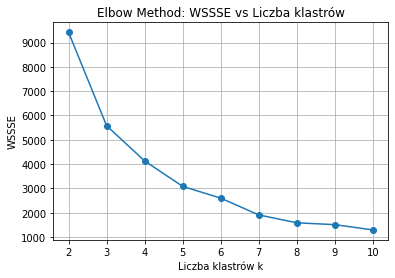

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

# Obliczenie WSSSE dla różnych wartości k
# WSSE (Within-Cluster Sum of Squared Errors) to miara jakości klasteryzacji, często stosowana przy wyborze optymalnej liczby klastrów 𝐾 w algorytmie K-Means. WSSE oblicza sumę kwadratów odległości między punktami w klastrze a jego centroidem—im mniejsza wartość WSSE, tym bardziej spójne są klastry.W praktyce, WSSE jest wykorzystywane do metody „łokcia” (elbow method), gdzie wykres wartości WSSE dla różnych 𝐾 pozwala znaleźć punkt, w którym dalsze zwiększanie liczby klastrów przestaje znacząco poprawiać jakość podziału. Szukając „załamania” na wykresie, można dobrać optymalną wartość 𝐾 


ks = list(range(2, 11))
costs = []

for k in ks:
    km = KMeans(featuresCol="rfm_scaled", k=k, seed=42)
    model = km.fit(rfm_scaled)

    # trainingCost to WSSSE, zmienna trainingCost reprezentuje wartość WSSSE, czyli wewnętrzną sumę kwadratów błędów w klastrach.


    wssse = model.summary.trainingCost
    costs.append((k, wssse))

# Zamiana na Pandas, by narysować wykres

costs_pdf = pd.DataFrame(costs, columns=["k", "WSSSE"])

# Wykres łokcia

plt.figure()
plt.plot(costs_pdf['k'], costs_pdf['WSSSE'], marker='o')
plt.xticks(costs_pdf['k'])
plt.xlabel('Liczba klastrów k')
plt.ylabel('WSSSE')
plt.title('Elbow Method: WSSSE vs Liczba klastrów')
plt.grid(True)
plt.show()



In [0]:
from pyspark.ml.clustering import KMeans

# Konfiguracja K-Means (k=4) z kolumną predykcji

kmeans = KMeans(featuresCol="rfm_scaled", predictionCol="cluster", k=4, seed=42)

# Trenowanie modelu

model = kmeans.fit(rfm_scaled)

# Dodanie etykiety klastrów

rfm_clustered = model.transform(rfm_scaled)

# Obliczanie Silhouette Score

from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="rfm_scaled", predictionCol="cluster")
silhouette_score = evaluator.evaluate(rfm_clustered)

print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: 0.7549859440052721


K means clustering

In [0]:
from pyspark.ml.clustering import KMeans

# Konfiguracja KMeans (k=4)

kmeans = KMeans(
    featuresCol   = "rfm_scaled",
    predictionCol = "cluster",
    k             = 4,
    seed          = 42
)

# Trenowanie modelu

model = kmeans.fit(rfm_scaled)

# Dodanie etykiety klastra do DataFrame

rfm_clustered = model.transform(rfm_scaled)

# Podgląd wyników (klient, recency, frequency, monetary, cluster)

display(
    rfm_clustered
      .select("CustomerID_int", "Recency", "Frequency", "Monetary", "cluster")
      .limit(10)
)

# Wypisanie centroidów w zeskalowanej przestrzeni

centroids = model.clusterCenters()
print("Centroidy w przestrzeni zeskalowanej:")
for idx, c in enumerate(centroids):
    print(f"Cluster {idx}: {c}")


CustomerID_int,Recency,Frequency,Monetary,cluster
15727,4958,7,5178.96,0
17389,4942,43,31300.08,1
16503,5048,5,1421.4299999999998,0
17420,4992,3,598.8299999999999,0
15447,5272,1,155.17,2
16861,5001,3,151.65,0
14450,5122,3,483.25,2
13623,4972,7,672.44,0
13285,4965,4,2709.1199999999994,0
14570,5222,2,218.05999999999997,2


Centroidy w przestrzeni zeskalowanej:
Cluster 0: [-0.51498016  0.03950892 -0.01853727]
Cluster 1: [-0.8614187   7.58773625  5.36200161]
Cluster 2: [ 1.52957719 -0.34509155 -0.17493068]
Cluster 3: [-0.87902469  6.38106382 29.10671059]


Profilowanie klastrów

In [0]:
from pyspark.sql import functions as F

profile = (
    rfm_clustered
      .groupBy("cluster")
      .agg(
          F.round(F.avg("Recency"), 1)  .alias("avg_recency"),
          F.round(F.avg("Frequency"), 1).alias("avg_frequency"),
          F.round(F.avg("Monetary"), 1) .alias("avg_monetary"),
          F.count("CustomerID_int"       ).alias("count_customers")
      )
      .orderBy("cluster")
)

display(profile)


cluster,avg_recency,avg_frequency,avg_monetary,count_customers
0,4981.7,5.4,1746.1,3231
1,4946.8,75.9,45970.6,31
2,5187.7,1.9,460.6,1107
3,4945.0,64.7,241136.6,3


Histogramy RFM i wykresy profilu klastrów

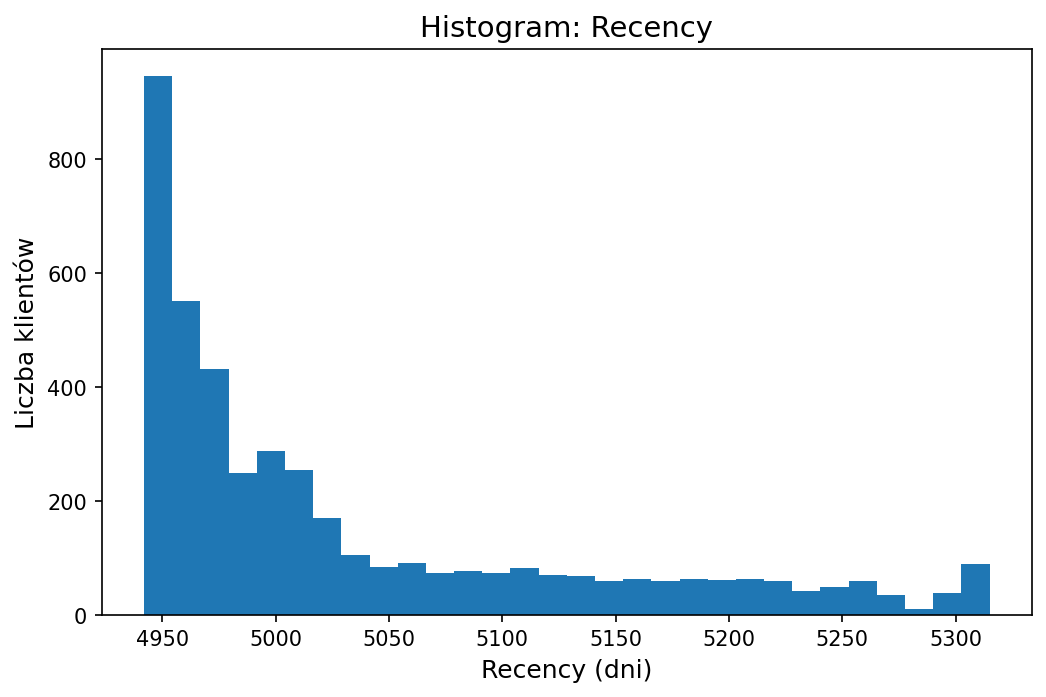

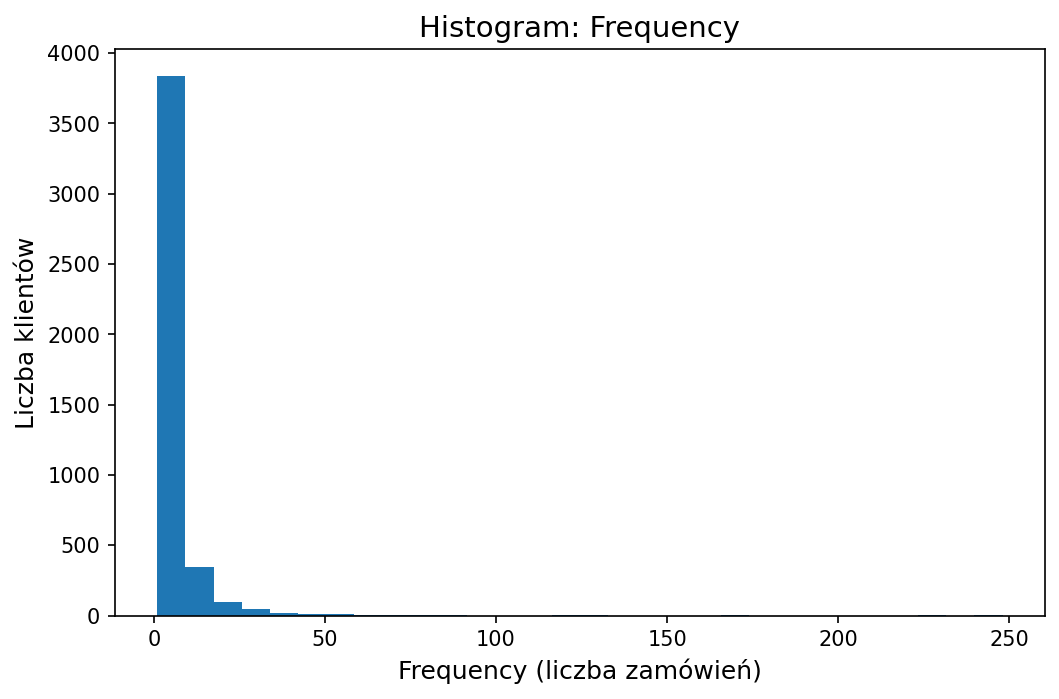

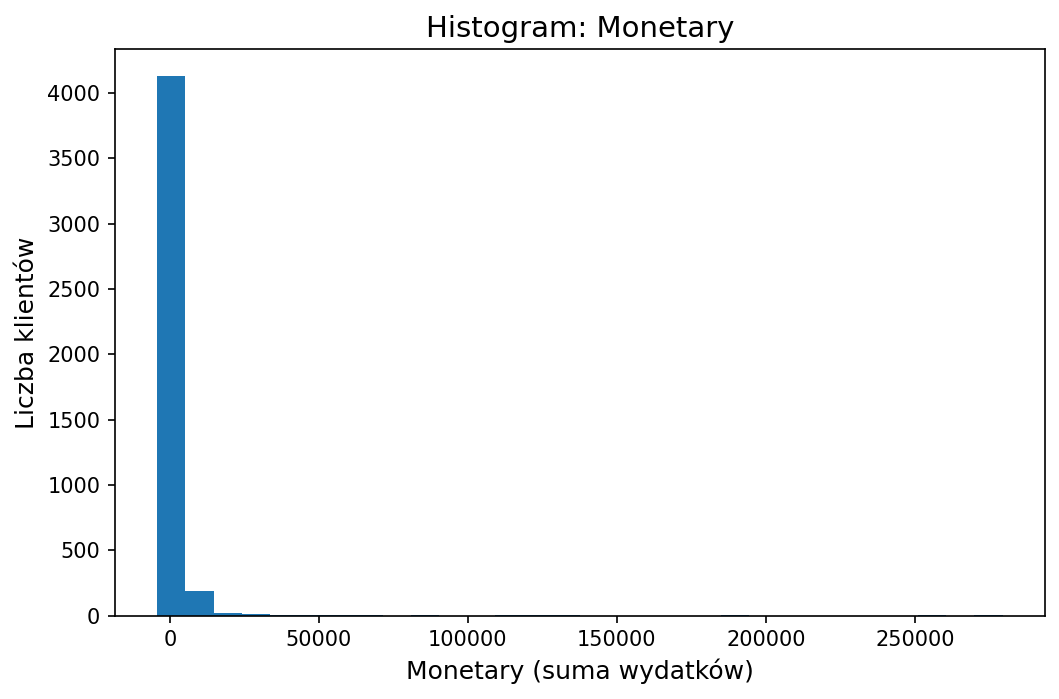

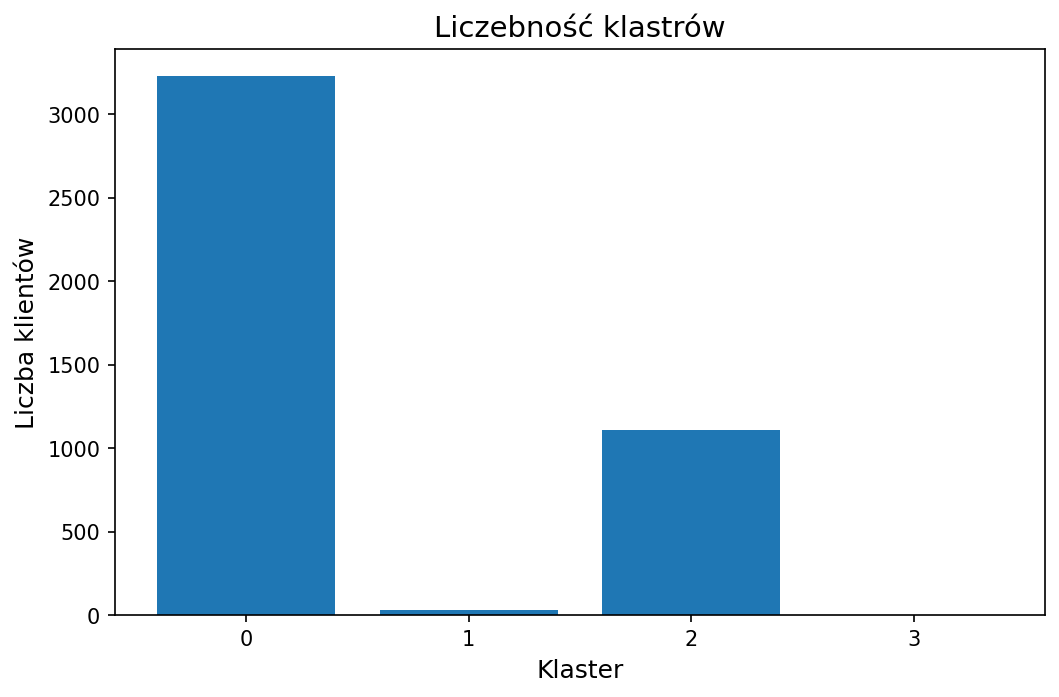

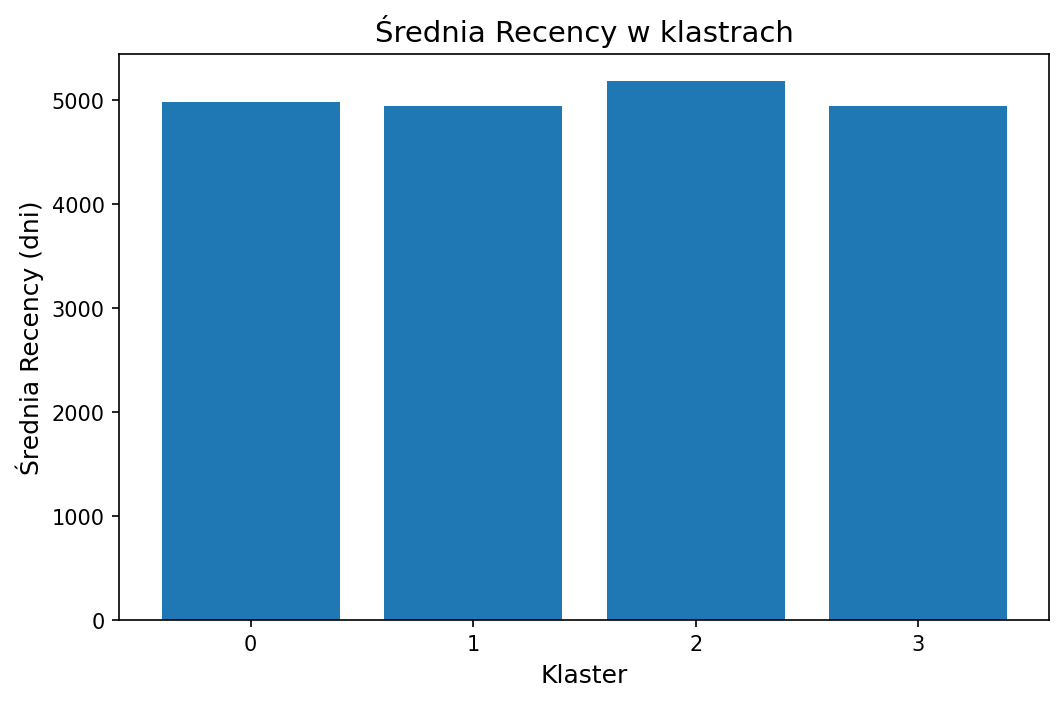

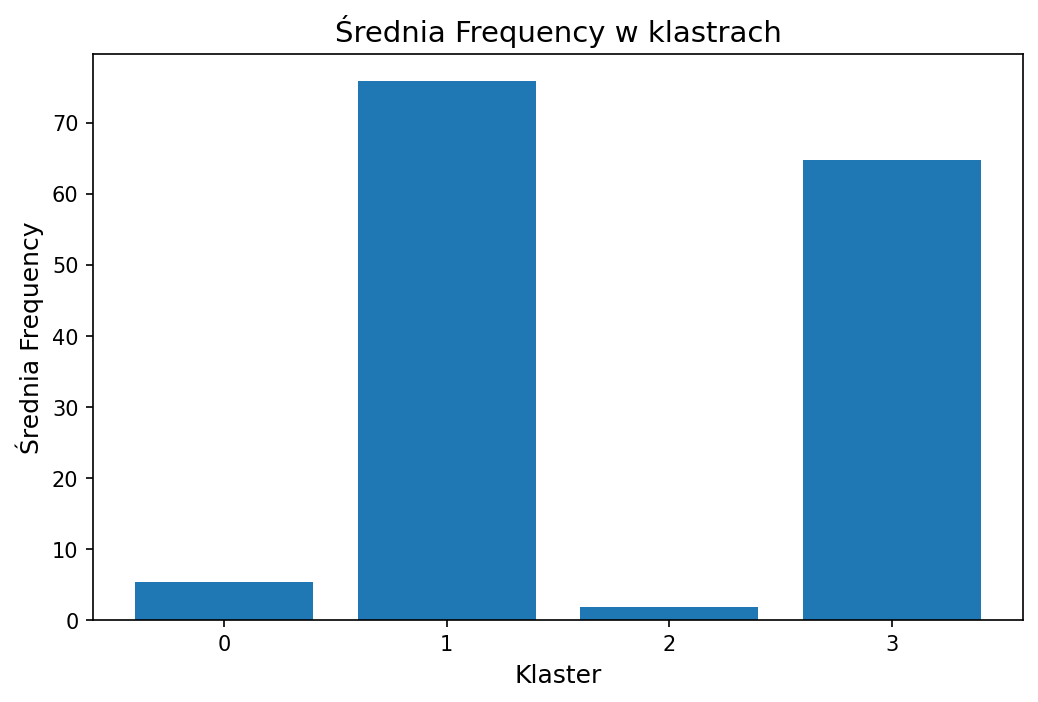

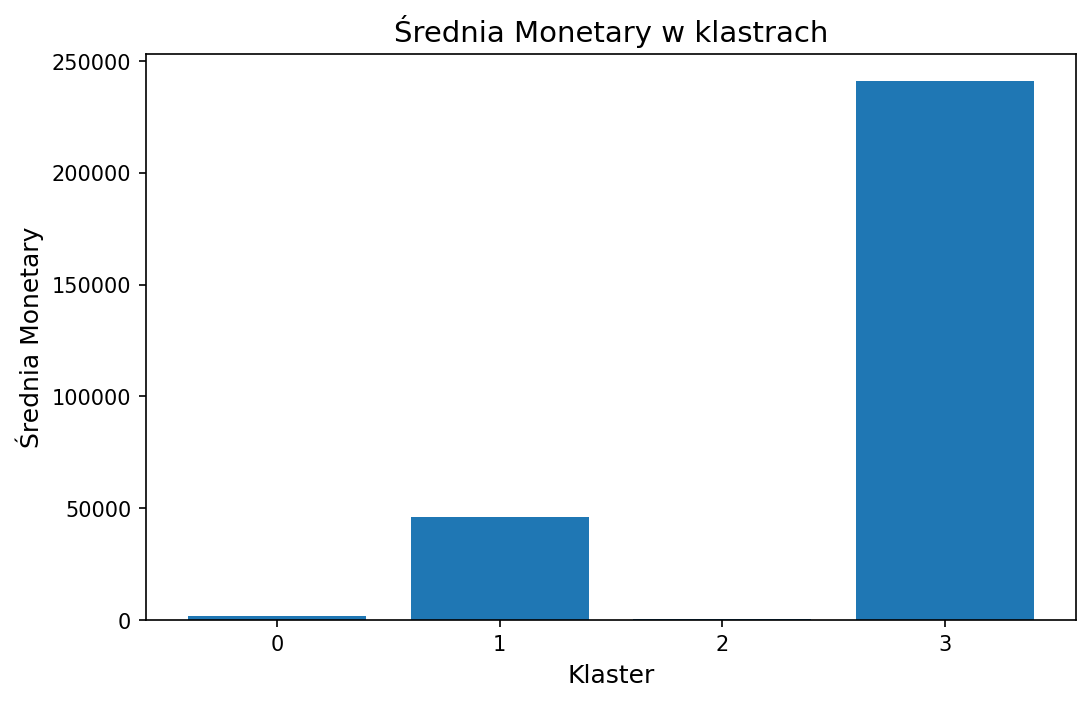

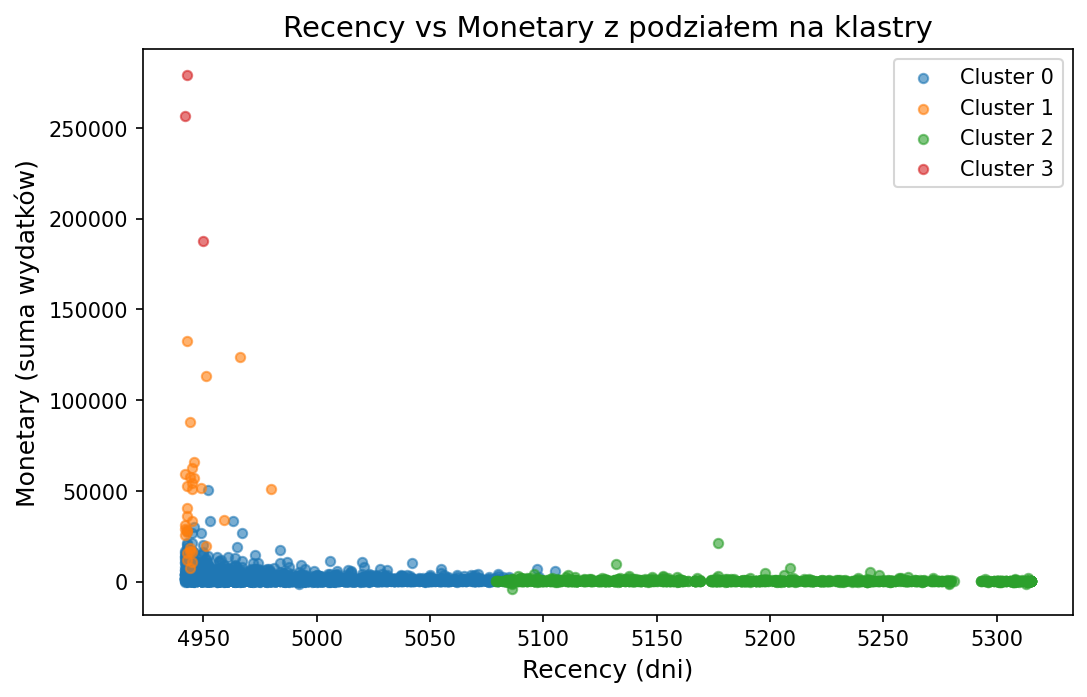

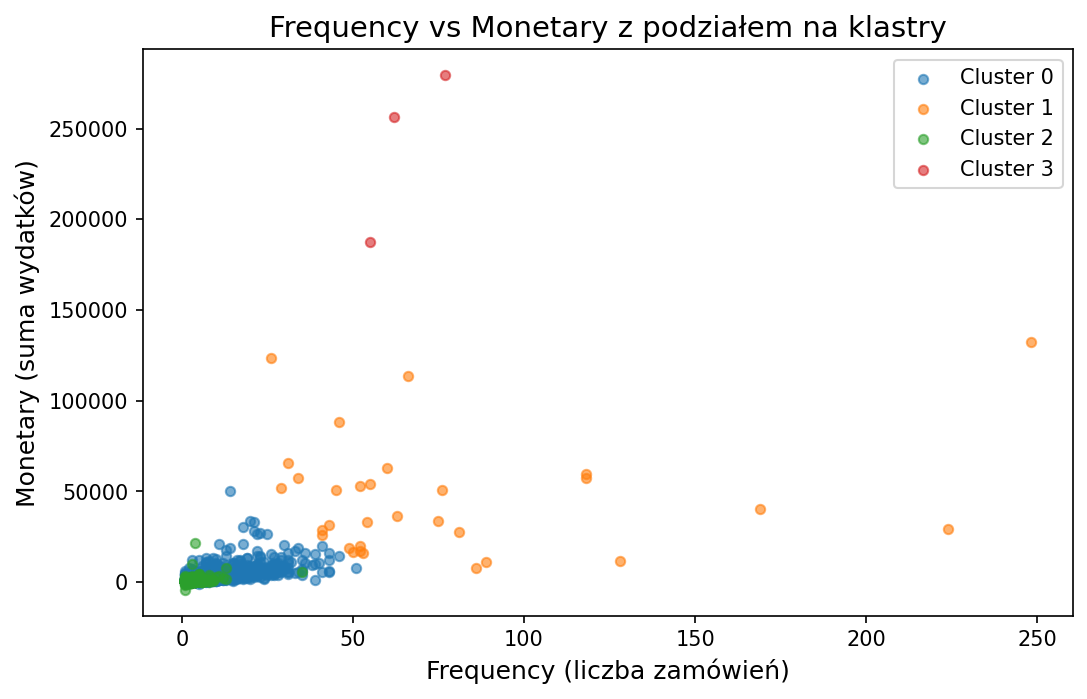

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 150,          # wyższa rozdzielczość w notatniku
    "savefig.dpi": 300,         # do zapisu plików PNG
    "figure.figsize": (8, 5),   # większy rozmiar wykresów
    "axes.titlesize": 14,       # większy tytuł
    "axes.labelsize": 12,       # większe opisy osi
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

# Konwertowanie Spark DataFrame 'rfm' do Pandas

rfm_pdf = rfm.toPandas()

# Histogram: Recency

plt.figure()
plt.hist(rfm_pdf['Recency'], bins=30)
plt.xlabel('Recency (dni)')
plt.ylabel('Liczba klientów')
plt.title('Histogram: Recency')
plt.show()

# Histogram: Frequency

plt.figure()
plt.hist(rfm_pdf['Frequency'], bins=30)
plt.xlabel('Frequency (liczba zamówień)')
plt.ylabel('Liczba klientów')
plt.title('Histogram: Frequency')
plt.show()

# Histogram: Monetary

plt.figure()
plt.hist(rfm_pdf['Monetary'], bins=30)
plt.xlabel('Monetary (suma wydatków)')
plt.ylabel('Liczba klientów')
plt.title('Histogram: Monetary')
plt.show()


# Wykresy profilu klastrów

# Konwertowani Spark DataFrame 'profile' do Pandas

profile_pdf = profile.toPandas()

# Wykres liczby klientów w każdym klastrze

plt.figure()
plt.bar(profile_pdf['cluster'].astype(str), profile_pdf['count_customers'])
plt.xlabel('Klaster')
plt.ylabel('Liczba klientów')
plt.title('Liczebność klastrów')
plt.show()

# Wykres średnia Recency per cluster

plt.figure()
plt.bar(profile_pdf['cluster'].astype(str), profile_pdf['avg_recency'])
plt.xlabel('Klaster')
plt.ylabel('Średnia Recency (dni)')
plt.title('Średnia Recency w klastrach')
plt.show()

# Wykres średnia Frequency per cluster

plt.figure()
plt.bar(profile_pdf['cluster'].astype(str), profile_pdf['avg_frequency'])
plt.xlabel('Klaster')
plt.ylabel('Średnia Frequency')
plt.title('Średnia Frequency w klastrach')
plt.show()

# Wykres średnia Monetary per cluster

plt.figure()
plt.bar(profile_pdf['cluster'].astype(str), profile_pdf['avg_monetary'])
plt.xlabel('Klaster')
plt.ylabel('Średnia Monetary')
plt.title('Średnia Monetary w klastrach')
plt.show()


# Wykres rozrzutu: Recency vs Monetary z podziałem na klastry

# Konwertowanie Spark DataFrame 'rfm_clustered' do Pandas

rfm_clustered_pdf = rfm_clustered.select("Recency", "Frequency", "Monetary", "cluster").toPandas()

plt.figure()

# Osobny podzbiór punktów dla każdego klastra 

clusters = sorted(rfm_clustered_pdf['cluster'].unique())
for c in clusters:
    subset = rfm_clustered_pdf[rfm_clustered_pdf['cluster'] == c]
    plt.scatter(subset['Recency'], subset['Monetary'], label=f'Cluster {c}', alpha=0.6, s=20)
plt.xlabel('Recency (dni)')
plt.ylabel('Monetary (suma wydatków)')
plt.title('Recency vs Monetary z podziałem na klastry')
plt.legend()
plt.show()


# Wykres rozrzutu: Frequency vs Monetary z podziałem na klastry

plt.figure()
for c in clusters:
    subset = rfm_clustered_pdf[rfm_clustered_pdf['cluster'] == c]
    plt.scatter(subset['Frequency'], subset['Monetary'], label=f'Cluster {c}', alpha=0.6, s=20)
plt.xlabel('Frequency (liczba zamówień)')
plt.ylabel('Monetary (suma wydatków)')
plt.title('Frequency vs Monetary z podziałem na klastry')
plt.legend()
plt.show()


Treemap z segmentami RFM

In [0]:
# konwersja z Spark do Pandas
rfm_pdf = rfm_clustered.select("CustomerID_int", "cluster").toPandas()

#przypisanie etykiet opisowych do klastrów
cluster_labels = {
    0: "Standardowy klient",
    1: "Lojalny i wartościowy klient",
    2: "Nieaktywny lub okazjonalny klient",
    3: "Kluczowy klient o wysokiej wartości"
}
rfm_pdf["Segment"] = rfm_pdf["cluster"].map(cluster_labels)

#podsumowanie liczby klientów w każdym segmencie
segment_summary = rfm_pdf["Segment"].value_counts().reset_index()
segment_summary.columns = ["Segment", "Liczba klientów"]

#dodanie etykiety z procentem
total = segment_summary["Liczba klientów"].sum()
segment_summary["Label"] = segment_summary.apply(
    lambda row: f"{row['Segment']}<br>{row['Liczba klientów']} ({row['Liczba klientów']/total:.1%})",
    axis=1
)

#wykres treemap
import plotly.express as px

fig = px.treemap(
    segment_summary,
    path=["Label"],
    values="Liczba klientów",
    title="Treemap – podział klientów wg segmentów KMeans"
)
fig.show()


/databricks/python/lib/python3.9/site-packages/plotly/express/_core.py:1637: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
